# Lesson 1: Introduction to Deep Learning with PyTorch
- [@AlfredoCanziani](https://twitter.com/alfredocanziani)
- [@GokuMohandas](https://twitter.com/GokuMohandas)

### What is PyTorch ?

### Why PyTorch ?

### Code

In [46]:
import os
import sys
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

from pycrayon import (
    CrayonClient,
)

from IPython import (
    display,
)

from IPython.display import (
    Image,
    clear_output,
)

%matplotlib inline
plt.style.use('fivethirtyeight')

In [47]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)

### Create the data

<img src="images/nn.gif">

In [48]:
seed=12345
random.seed(seed)
torch.manual_seed(seed)
N = 1000 # num_samples_per_class
D = 2 # dimensions
C = 4 # num_classes
H = 100 # num_hidden_units

In [49]:
X = torch.zeros((N*C, D))
y = torch.zeros((N*C))
for i in range(C):
    index = 0
    r = torch.linspace(0, 1, N)
    t = torch.linspace(i*4,(i+1)*4,N) + torch.randn(N)*0.1
    for ix in range(N*i, N*(i+1)):
        X[ix] = torch.FloatTensor(
            (r[index]*np.sin(t[index]), r[index]*np.cos(t[index])), )
        y[ix] = i
        index += 1

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([4000, 2])
y: torch.Size([4000])


In [63]:
def plot_data(X, y):
    """
    Plot the data.
    """
    plt.scatter (X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.show ()

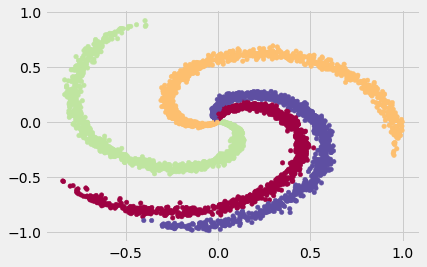

In [64]:
# Create the data
plot_data(X.numpy(), y.numpy())

### Create train/test sets

In [65]:
split_ratio = 0.8 # train-test split
num_epochs = 100
batch_size = 64
log_every = 25

In [66]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 3200 train samples and 800 test samples.


In [67]:
# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

In [68]:
# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Processing functions

In [134]:
def process_batch(batch, model, criterion, optimizer, is_training, clipping=False):
    """
    Process a minibatch for loss and accuracy.
    """
    X_batch = batch[:,:2]
    y_batch = batch[:, 2]

    # Convert tensors to Variables (for autograd)
    X_batch = Variable(X_batch, requires_grad=False)
    y_batch = Variable(y_batch.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # Use autograd to do backprop. This will compute the
        # gradients w.r.t loss for all Variables that have
        # requires_grad=True. So, our w1 and w2 will now have
        # gradient components we can access.
        optimizer.zero_grad()
        loss.backward()
        
        if clipping:
            # Clip the gradient norms
            nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [190]:
def train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2):
    """
    Training our model.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy  
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (test_batch) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(test_batch))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
            
        # Verbose
        if (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1):

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    # Plot global metrics
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(5,15))
    
    ax1.plot(train_loss, label='train loss')
    ax1.plot(test_loss, label='test loss')
    ax1.legend(loc=3)
    ax1.title('Loss')
    
    ax2.plot(train_acc, label='train accuracy')
    ax2.plot(test_acc, label='test accuracy')
    ax2.legend(loc=4)
    ax2.title('Accuracy')
    
    plt.show()
            
    return model

In [191]:
def hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Metrics
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training, clipping=True)

            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss/float(train_batch_num+1))
        train_acc.append(train_batch_accuracy/float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):

            # Metrics
            test_batch_loss = 0.0
            test_batch_accuracy = 0.0

            for test_batch_num, (test_batch) in enumerate(test_loader):

                # Get metrics
                model.eval()
                loss, accuracy = \
                    process_batch(test_batch, model, criterion, optimizer, model.training, clipping=True)

                # Add to batch scalars
                test_batch_loss += loss.data[0] / float(len(test_batch))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss/float(test_batch_num+1))
            test_acc.append(test_batch_accuracy/float(test_batch_num+1))
                
            if animate:
                verbose_condition = num_train_epoch == num_epochs-1
                if num_train_epoch%10 == 0:
                    plot_model(X, y, model)
                    display.clear_output(wait=True)
            else:
                verbose_condition = \
                    (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

            # Verbose
            if verbose_condition:

                # Verbose
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
                minutes = time_remain // 60
                seconds = time_remain - minutes*60
                print ("TIME REMAINING: %im %is" % (minutes, seconds))
                print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                       (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                        train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                        test_batch_accuracy/float(test_batch_num+1)))
            
    # Plot global metrics
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='train loss')
    plt.plot(test_loss, label='test loss')
    plt.legend(loc=3)
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train accuracy')
    plt.plot(test_acc, label='test accuracy')
    plt.legend(loc=4)
    plt.title('Accuracy')
    
    plt.show()
    
    return model

In [192]:
def plot_model(X, y, model):
    """
    Plot the model from torch weights.
    """
    
    X = X.numpy()
    y = y.numpy(),
    w1 = torch.transpose(model.fc1.weight.data, 0, 1).numpy()
    b1 = model.fc1.bias.data.numpy()
    w2 = torch.transpose(model.fc2.weight.data, 0, 1).numpy()
    b2 = model.fc2.bias.data.numpy()
    
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], w1) + b1), w2) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

### Linear model

In [193]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [194]:
# Linear model
class LinearModel(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = self.fc1(x)
        z = self.fc2(z)
        return z

TIME REMAINING: 0m 5s
[EPOCH]: 0, [TRAIN LOSS]: 0.019755, [TRAIN ACC]: 0.352, [TEST LOSS]: 0.019378, [TEST ACC]: 0.393
TIME REMAINING: 0m 3s
[EPOCH]: 25, [TRAIN LOSS]: 0.016289, [TRAIN ACC]: 0.400, [TEST LOSS]: 0.017568, [TEST ACC]: 0.399
TIME REMAINING: 0m 2s
[EPOCH]: 50, [TRAIN LOSS]: 0.016287, [TRAIN ACC]: 0.399, [TEST LOSS]: 0.017568, [TEST ACC]: 0.399
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.016284, [TRAIN ACC]: 0.397, [TEST LOSS]: 0.017568, [TEST ACC]: 0.395
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.016282, [TRAIN ACC]: 0.396, [TEST LOSS]: 0.017568, [TEST ACC]: 0.391


TypeError: 'Text' object is not callable

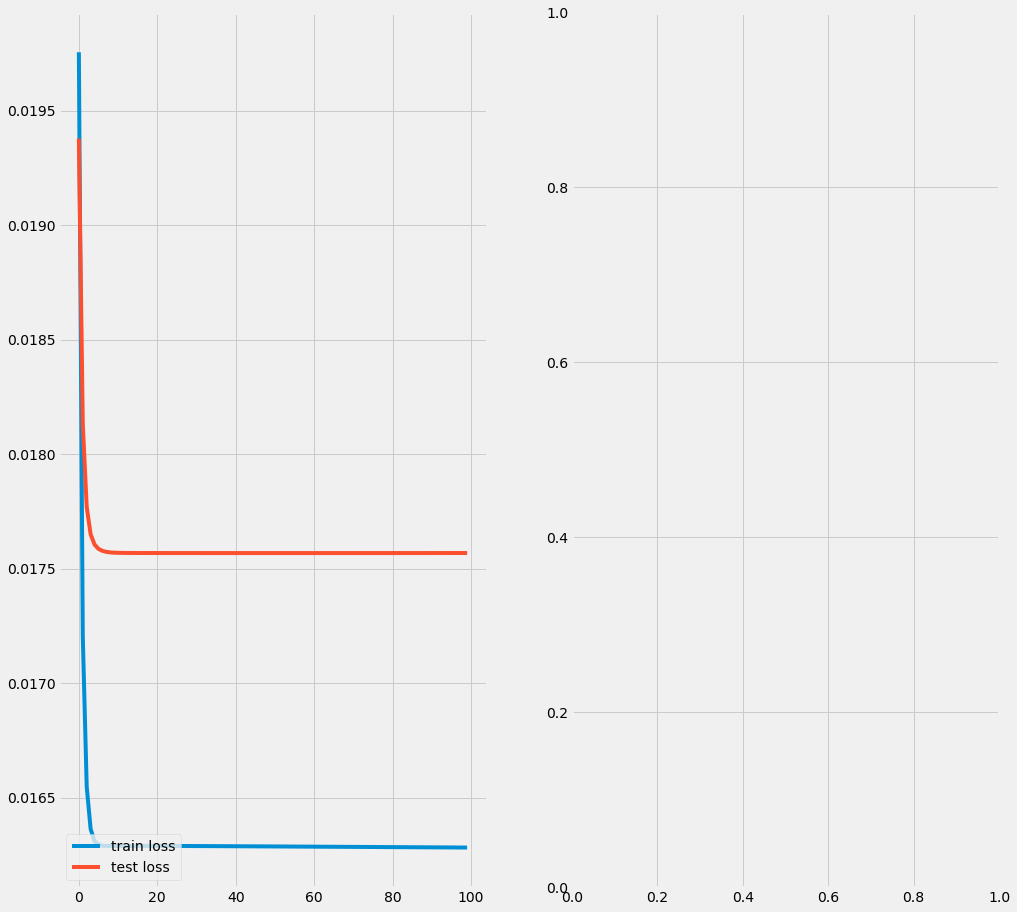

In [195]:
# Create model
model = LinearModel(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

LinearModel (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
)


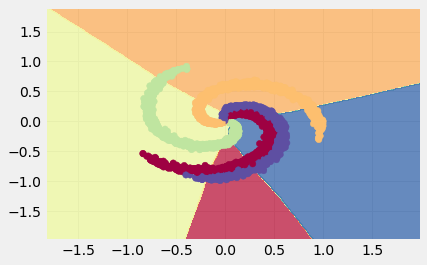

In [181]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Two-layered Network

In [182]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [183]:
# Linear model
class NN(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(NN, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.fc2(z)
        return z

TIME REMAINING: 0m 7s
[EPOCH]: 0, [TRAIN LOSS]: 0.019612, [TRAIN ACC]: 0.408, [TEST LOSS]: 0.019939, [TEST ACC]: 0.434
TIME REMAINING: 0m 5s
[EPOCH]: 25, [TRAIN LOSS]: 0.007398, [TRAIN ACC]: 0.825, [TEST LOSS]: 0.008361, [TEST ACC]: 0.794
TIME REMAINING: 0m 3s
[EPOCH]: 50, [TRAIN LOSS]: 0.004415, [TRAIN ACC]: 0.936, [TEST LOSS]: 0.005187, [TEST ACC]: 0.934
TIME REMAINING: 0m 1s
[EPOCH]: 75, [TRAIN LOSS]: 0.002993, [TRAIN ACC]: 0.964, [TEST LOSS]: 0.003648, [TEST ACC]: 0.962
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002224, [TRAIN ACC]: 0.976, [TEST LOSS]: 0.002796, [TEST ACC]: 0.969


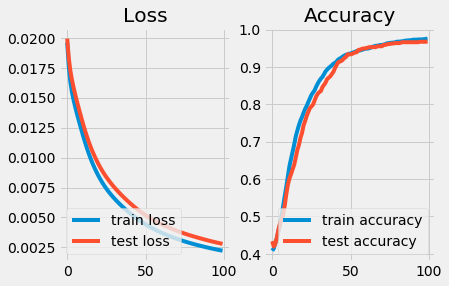

In [184]:
# Create model
model = NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = train(model, criterion, optimizer, train_loader, test_loader, 
      num_epochs, batch_size, log_every, learning_rate, lambda_l2)

NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
)


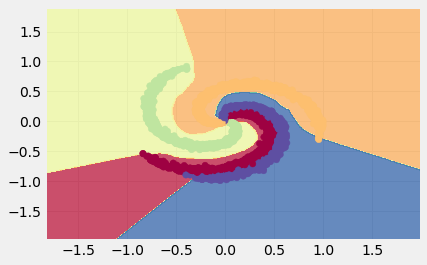

In [185]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Custom Components

In [186]:
learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

In [187]:
# Linear model
class hyper_NN(nn.Module):
    """
    Linaer model.
    """
    def __init__(self, D_in, H, D_out):
        """
        Initialize weights.
        """
        super(hyper_NN, self).__init__()
        self.fc1 = nn.Linear(D_in, H)
        self.fc2 = nn.Linear(H, D_out)
        self.dropout = nn.Dropout(dropout_p)
        
        # Initialize weights
        self.init_weights()
        
    def init_weights(self):
        """
        Properly initialize weights.
        """
        init.xavier_uniform(self.fc1.weight, gain=np.sqrt(2.0)) # gain for ReLU

    def forward(self, x):
        """
        Forward pass.
        """
        z = F.relu(self.fc1(x))
        z = self.dropout(z)
        z = self.fc2(z)
        return z

TIME REMAINING: 0m 8s
[EPOCH]: 0, [TRAIN LOSS]: 0.021041, [TRAIN ACC]: 0.372, [TEST LOSS]: 0.021891, [TEST ACC]: 0.416
TIME REMAINING: 0m 4s
[EPOCH]: 25, [TRAIN LOSS]: 0.010205, [TRAIN ACC]: 0.719, [TEST LOSS]: 0.011006, [TEST ACC]: 0.680
TIME REMAINING: 0m 3s
[EPOCH]: 50, [TRAIN LOSS]: 0.007212, [TRAIN ACC]: 0.847, [TEST LOSS]: 0.007654, [TEST ACC]: 0.837
TIME REMAINING: 0m 2s
[EPOCH]: 75, [TRAIN LOSS]: 0.005949, [TRAIN ACC]: 0.867, [TEST LOSS]: 0.006157, [TEST ACC]: 0.906
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.005319, [TRAIN ACC]: 0.877, [TEST LOSS]: 0.005364, [TEST ACC]: 0.921


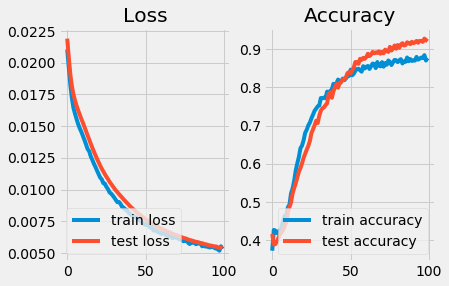

In [188]:
# Create model
model = hyper_NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Train
model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm)

hyper_NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
  (dropout): Dropout (p = 0.1)
)


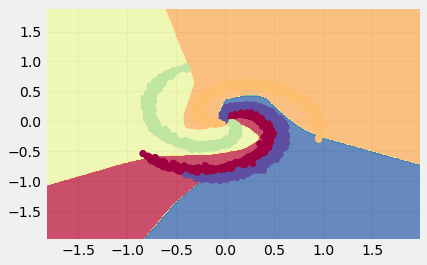

In [189]:
# Plot trained model
print (model)
plot_model(X, y, model)

### Custom autograd

In [154]:
class ReLU(torch.autograd.Function):
    """
    Use autograd variables for implicit 
    backprop and make your own autograd 
    func. Just implemnet forward and 
    backward pass.
    """

    def forward(self, input_):
        """
        Process inputs and use
        save_for_backward to store
        inputs for backprop.
        """
        self.save_for_backward(input_)
        return input_.clamp(min=0)

    def backward(self, grad_output):
        """
        grad_output is the grad w.r.t loss.
        """
        input_, =self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input_ < 0] = 0
        return grad_input

In [155]:
# custom autograd func.
relu = ReLU()

# Forward pass
h = Variable(torch.ones((2,3)), requires_grad=True)
h_relu = relu(h)

### Save/load models

In [156]:
# Save the model
torch.save(model, os.path.join("model_hyper_NN.pt"))

/Users/GokuMohandas/Documents/oreilly-pytorch/venv/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type hyper_NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [157]:
# Load the model
model = torch.load(os.path.join("model_hyper_NN.pt"))

### Inference

In [158]:
X_infer = Variable(X[0].view(1, -1))
y_infer = Variable(y[:1])
print ("X_infer:\n", X_infer)
print ("y_infer:\n", y_infer)

X_infer:
 Variable containing:
-0.1287 -0.0103
[torch.FloatTensor of size 1x2]

y_infer:
 Variable containing:
 1
[torch.FloatTensor of size 1]



In [159]:
# Feed through model
model.eval()
scores = model(X_infer)
probabilities = F.softmax(scores)

# Sorted probabilities
sorted_, indices = torch.sort(probabilities, descending=True)
for i, index in enumerate(indices[0]):
    print ("%i - %i%%" % (
        indices[0].data[i],
        100.0*probabilities.data[0][index.data[0]]))

1 - 68%
2 - 17%
0 - 7%
3 - 6%


### Hyperparameters

Let's see how changing our hyperparameters can alter the model.

TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.006386, [TRAIN ACC]: 0.848, [TEST LOSS]: 0.006436, [TEST ACC]: 0.871


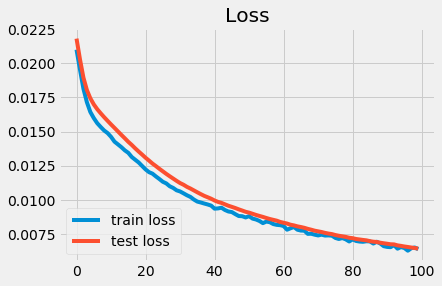

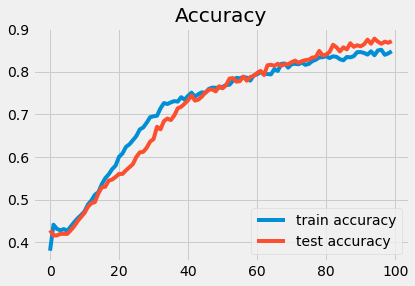

hyper_NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
  (dropout): Dropout (p = 0.1)
)


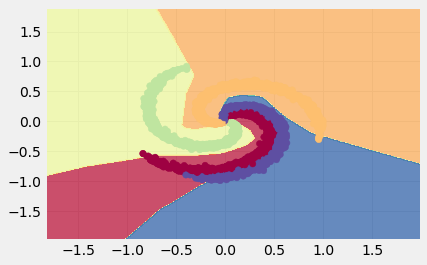

In [160]:
model = hyper_NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

learning_rate = 1e-3
lambda_l2 = 1e-5
dropout_p = 0.1
decay_rate = 0.9999
max_grad_norm = 5.0

model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=True)
# Plot trained model
print (model)
plot_model(X, y, model)

### Visualization / debugging

- Takes more time to run models but is very useful for debugging.

In [92]:
# Connect to the server for Crayon (tensorboard)
cc = CrayonClient(hostname="localhost", port=8889)

In [93]:
# Create a new experiment
exp_name = "hyper_model"
try:
    cc.remove_experiment(exp_name)
    exp = cc.create_experiment(exp_name)
except:
    exp = cc.create_experiment(exp_name)

In [94]:
def crayon_train(exp, model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False):
    """
    Training with a few extra (nice) components.
    """
    
    # Training
    for num_train_epoch in range(num_epochs):

        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss = 0.0
        train_batch_accuracy = 0.0

        for train_batch_num, (train_batch) in enumerate(train_loader):

            # Get metrics
            model.train()
            loss, accuracy = process_batch(train_batch, model, criterion, optimizer, model.training, clipping=True)

            # Collect weights
            exp.add_histogram_value(
                "W2", hist=list(model.fc2.weight.data.view(-1, )), tobuild=True)
            
            # Add to batch scalars
            train_batch_loss += loss.data[0] / float(len(train_batch))
            train_batch_accuracy += accuracy
            
            # Record metrics
            exp.add_scalar_value("train_loss", value=loss.data[0] / float(len(train_batch)))
            exp.add_scalar_value("train_accuracy", value=accuracy)
            
        if animate:
            verbose_condition = num_train_epoch == num_epochs-1
            if num_train_epoch%10 == 0:
                plot_model(X, y, model)
                display.clear_output(wait=True)
        else:
            verbose_condition = (num_train_epoch == 0) or (num_train_epoch % log_every == 0) or (num_train_epoch == num_epochs-1)

        # Verbose
        if verbose_condition:

            # Testing
            model.eval()
            for num_test_epoch in range(1):

                # Metrics
                test_batch_loss = 0.0
                test_batch_accuracy = 0.0

                for test_batch_num, (test_batch) in enumerate(test_loader):

                    # Get metrics
                    model.eval()
                    loss, accuracy = process_batch(test_batch, model, criterion, optimizer, model.training, clipping=True)

                    # Add to batch scalars
                    test_batch_loss += loss.data[0] / float(len(test_batch))
                    test_batch_accuracy += accuracy
                    
                    # Record metrics
                    exp.add_scalar_value("test_loss", value=loss.data[0] / float(len(test_batch)))
                    exp.add_scalar_value("test_accuracy", value=accuracy)

            # Verbose
            time_remain = (time.time() - start) * (num_epochs - (num_train_epoch+1))
            minutes = time_remain // 60
            seconds = time_remain - minutes*60
            print ("TIME REMAINING: %im %is" % (minutes, seconds))
            print ("[EPOCH]: %i, [TRAIN LOSS]: %.6f, [TRAIN ACC]: %.3f, [TEST LOSS]: %.6f, [TEST ACC]: %.3f" %
                   (num_train_epoch, train_batch_loss/float(train_batch_num+1), 
                    train_batch_accuracy/float(train_batch_num+1), test_batch_loss/float(test_batch_num+1),
                    test_batch_accuracy/float(test_batch_num+1)))
            
    return model

In [95]:
crayon_train(exp, model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)

TIME REMAINING: 2m 24s
[EPOCH]: 0, [TRAIN LOSS]: 0.004968, [TRAIN ACC]: 0.890, [TEST LOSS]: 0.005091, [TEST ACC]: 0.938
TIME REMAINING: 1m 27s
[EPOCH]: 25, [TRAIN LOSS]: 0.004181, [TRAIN ACC]: 0.915, [TEST LOSS]: 0.004117, [TEST ACC]: 0.958
TIME REMAINING: 1m 1s
[EPOCH]: 50, [TRAIN LOSS]: 0.003506, [TRAIN ACC]: 0.930, [TEST LOSS]: 0.003473, [TEST ACC]: 0.966
TIME REMAINING: 0m 32s
[EPOCH]: 75, [TRAIN LOSS]: 0.003188, [TRAIN ACC]: 0.938, [TEST LOSS]: 0.003078, [TEST ACC]: 0.971
TIME REMAINING: 0m 0s
[EPOCH]: 99, [TRAIN LOSS]: 0.002811, [TRAIN ACC]: 0.948, [TEST LOSS]: 0.002820, [TEST ACC]: 0.972


hyper_NN (
  (fc1): Linear (2 -> 100)
  (fc2): Linear (100 -> 4)
  (dropout): Dropout (p = 0.1)
)

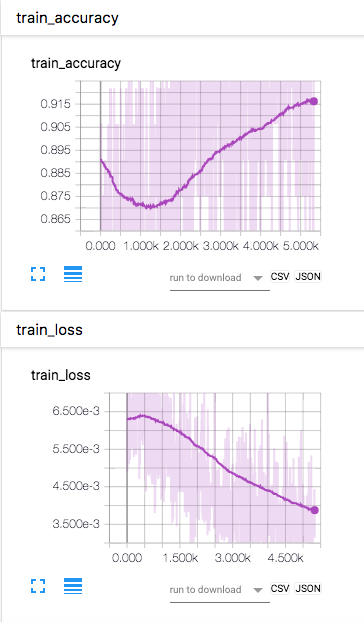

In [38]:
Image(filename='images/scalars.png') 

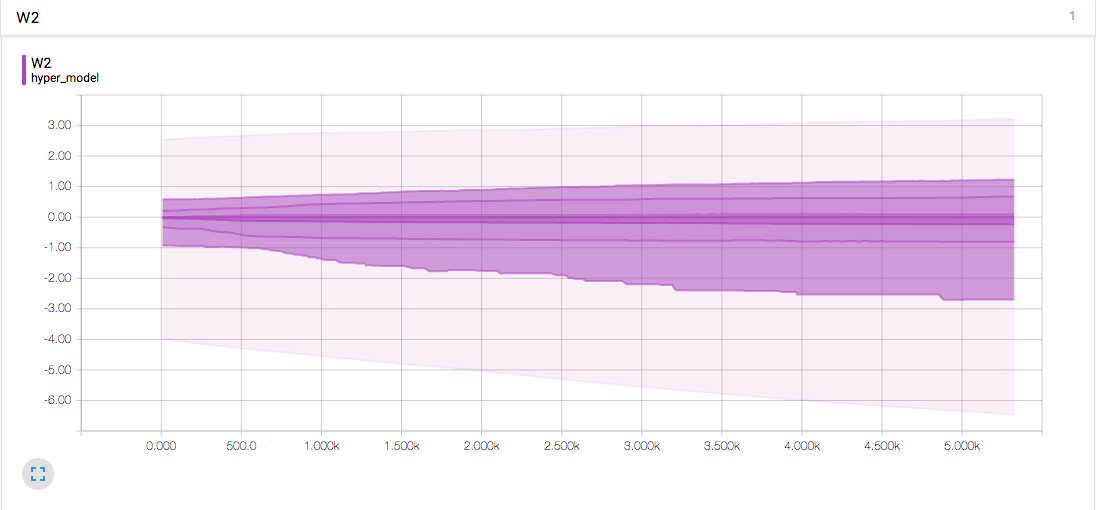

In [39]:
Image(filename='images/weights.png') 

### Caution

More data we have, the larger we can make our models and not suffer from overfitting. Things like dropout and finetuning regularization etc. will help us with getting better generalization but we still need to very cautious. In fact, with enough parameters, we can overfit to **completely random data**...

```
FINITE-SAMPLE EXPRESSIVITY:

"There exists a two-layer neural network with ReLU activations and 2n+d weights that can represent any function on a sample of size n in d dimensions”. This really demonstrates the brute-force capacity of neural nets for any dataset. The proof can be found in the appendix of https://arxiv.org/abs/1611.03530.
```

In [37]:
N = 1000
C = 3
H = 300
X = torch.randn(N*C, D)
y = torch.FloatTensor([[i]*N for i in range(C)]).view(-1)

print ("SHAPES:")
print ("-------------------")
print ("X:", X.size())
print ("y:", y.size())    

SHAPES:
-------------------
X: torch.Size([3000, 2])
y: torch.Size([3000])


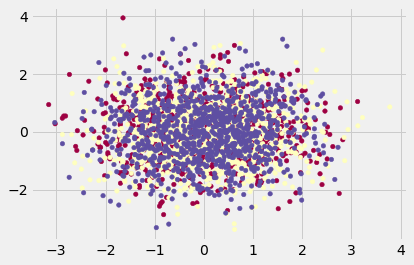

In [38]:
# Create the data
plot_data(X.numpy(), y.numpy())

In [39]:
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]
test_start_idx = int(len(X) * split_ratio)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print ("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

# Join X and y
train_data = torch.cat([X_train, y_train], 1)
test_data = torch.cat([X_test, y_test], 1)

# Data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

We have 2400 train samples and 600 test samples.


TIME REMAINING: 1m 34s
[EPOCH]: 0, [TRAIN LOSS]: 0.023596, [TRAIN ACC]: 0.326, [TEST LOSS]: 0.019789, [TEST ACC]: 0.356
TIME REMAINING: 1m 18s
[EPOCH]: 250, [TRAIN LOSS]: 0.018018, [TRAIN ACC]: 0.349, [TEST LOSS]: 0.020283, [TEST ACC]: 0.290
TIME REMAINING: 0m 30s
[EPOCH]: 500, [TRAIN LOSS]: 0.017916, [TRAIN ACC]: 0.340, [TEST LOSS]: 0.020010, [TEST ACC]: 0.307
TIME REMAINING: 0m 15s
[EPOCH]: 750, [TRAIN LOSS]: 0.018006, [TRAIN ACC]: 0.342, [TEST LOSS]: 0.020071, [TEST ACC]: 0.289
TIME REMAINING: 0m 0s
[EPOCH]: 999, [TRAIN LOSS]: 0.017864, [TRAIN ACC]: 0.350, [TEST LOSS]: 0.020347, [TEST ACC]: 0.283
hyper_NN (
  (fc1): Linear (2 -> 300)
  (fc2): Linear (300 -> 3)
  (dropout): Dropout (p = 0.1)
)


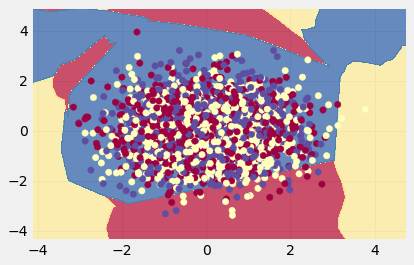

In [40]:
model = hyper_NN(D_in=D, H=H, D_out=C)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

num_epochs = 1000
log_every = 250
learning_rate = 1e-1
lambda_l2 = 0
dropout_p = 0.1
decay_rate = 1
max_grad_norm = 5.0

model = hyper_train(model, criterion, optimizer, train_loader, test_loader, 
                num_epochs, batch_size, log_every, learning_rate, lambda_l2, 
                dropout_p, decay_rate, max_grad_norm, animate=False)
# Plot trained model
print (model)
plot_model(X, y, model)